# فاز 1

##  بارگذاری دیتاست

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # چون ResNet18 ورودی 224x224 می‌خواد
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # نرمال‌سازی استاندارد برای مدل‌های pretrained
])
dataset_path = "/content/drive/MyDrive/dataset3"
dataset = ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# تقسیم train و test
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.targets)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Classes: ['cats', 'dogs', 'horses']


## تعریف مدل ResNet18 و استخراج لایه‌ها

In [4]:
import torch.nn as nn
from torchvision import models

# بارگذاری ResNet18 pretrained
resnet = models.resnet18(pretrained=True)

# بدون نیاز به grad چون feature extractor هست
for param in resnet.parameters():
    param.requires_grad = False

# استخراج سه نوع ویژگی:
# 1. ویژگی‌های ابتدایی: تا maxpool
features_low = nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool
)

# 2. ویژگی‌های میانی: تا layer2
features_mid = nn.Sequential(
    features_low,
    resnet.layer1,
    resnet.layer2
)

# 3. ویژگی‌های سطح بالا: تا avgpool
features_high = nn.Sequential(
    features_mid,
    resnet.layer3,
    resnet.layer4,
    resnet.avgpool
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features_low = features_low.to(device)
features_mid = features_mid.to(device)
features_high = features_high.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


## تابع استخراج ویژگی

In [5]:
!pip install tqdm


In [6]:
from tqdm import tqdm

def extract_features(dataloader, feature_extractor):
    features = []
    labels = []
    feature_extractor.eval()

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())

    X = np.concatenate(features, axis=0)
    y = np.concatenate(labels, axis=0)
    return X, y


In [7]:
# 👇 Train
X_low_tr ,  y_low_tr  = extract_features(train_loader,  features_low)
X_mid_tr ,  y_mid_tr  = extract_features(train_loader,  features_mid)
X_high_tr,  y_high_tr = extract_features(train_loader,  features_high)

# 👇 Test
X_low_te ,  y_low_te  = extract_features(test_loader,   features_low)
X_mid_te ,  y_mid_te  = extract_features(test_loader,   features_mid)
X_high_te,  y_high_te = extract_features(test_loader,   features_high)


Extracting Features: 100%|██████████| 4/4 [00:00<00:00, 30.53it/s]


## آموزش مدل‌های طبقه‌بندی و نتایج هرکدام

In [ ]:
# توابع نمایش تحلیل

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def show_confusion_matrix_fixed(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(title)
    plt.grid(False)
    plt.show()

def classification_metrics_fixed(y_true, y_pred, class_names):
    print("\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

def evaluate_models_detailed(X_tr, y_tr, X_te, y_te, class_names, title=""):
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.base import clone
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report, ConfusionMatrixDisplay
    )

    models = {
        "SVM": SVC(probability=True),
        "KNN": KNeighborsClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Extra Trees": ExtraTreesClassifier(),
        "Gaussian NB": GaussianNB()
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    print(f"\n🔍 Evaluation for: {title}\n{'-'*50}")

    for name, model in models.items():
        accuracies, precisions, recalls, f1s = [], [], [], []
        all_y_true, all_y_pred = [], []

        print(f"\nEvaluating {name}...")
        for train_idx, val_idx in tqdm(cv.split(X_tr, y_tr), total=cv.get_n_splits(), desc=f"{name} CV folds"):
            X_train, X_val = X_tr[train_idx], X_tr[val_idx]
            y_train, y_val = y_tr[train_idx], y_tr[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            all_y_true.extend(y_val)
            all_y_pred.extend(y_pred)

            accuracies.append(accuracy_score(y_val, y_pred))
            precisions.append(precision_score(y_val, y_pred, average='weighted', zero_division=0))
            recalls.append(recall_score(y_val, y_pred, average='weighted', zero_division=0))
            f1s.append(f1_score(y_val, y_pred, average='weighted', zero_division=0))

        results[name] = {
            "accuracy_mean": np.mean(accuracies),
            "accuracy_std": np.std(accuracies),
            "precision_mean": np.mean(precisions),
            "recall_mean": np.mean(recalls),
            "f1_mean": np.mean(f1s),
            "y_true": all_y_true,
            "y_pred": all_y_pred
        }

        classification_metrics_fixed(all_y_true, all_y_pred, class_names)
        #show_confusion_matrix_fixed(all_y_true, all_y_pred, class_names, title=f"Confusion Matrix - {name}")

    best_model = max(results.items(), key=lambda x: x[1]['accuracy_mean'])
    print(f"\n🏆 Best model based on Accuracy: **{best_model[0]}** with Accuracy = {best_model[1]['accuracy_mean']:.4f}")

    ## 🔎 گزارش نهایی روی Test
    best_clf = clone(models[best_model[0]])
    best_clf.fit(X_tr, y_tr)
    y_te_pred = best_clf.predict(X_te)

    print(f"\n📌 FINAL TEST REPORT for **{best_model[0]}**")
    classification_metrics_fixed(y_te, y_te_pred, class_names)
    show_confusion_matrix_fixed(y_te, y_te_pred, class_names,
                                title=f"Confusion Matrix (TEST) - {best_model[0]}")




### ویژگی های ابتدایی


🔍 Evaluation for: Low‑Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [19:28<00:00, 233.79s/it]




              precision    recall  f1-score   support

        cats       0.57      0.80      0.67       162
        dogs       0.61      0.43      0.50       161
      horses       0.85      0.75      0.80       161

    accuracy                           0.66       484
   macro avg       0.68      0.66      0.66       484
weighted avg       0.68      0.66      0.66       484


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]




              precision    recall  f1-score   support

        cats       0.42      0.86      0.57       162
        dogs       0.51      0.31      0.39       161
      horses       0.89      0.32      0.47       161

    accuracy                           0.50       484
   macro avg       0.61      0.50      0.47       484
weighted avg       0.61      0.50      0.47       484


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:38<00:00,  7.78s/it]




              precision    recall  f1-score   support

        cats       0.59      0.68      0.63       162
        dogs       0.57      0.50      0.53       161
      horses       0.81      0.79      0.80       161

    accuracy                           0.66       484
   macro avg       0.66      0.66      0.66       484
weighted avg       0.66      0.66      0.66       484


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [02:14<00:00, 26.81s/it]




              precision    recall  f1-score   support

        cats       0.62      0.71      0.66       162
        dogs       0.64      0.54      0.58       161
      horses       0.79      0.79      0.79       161

    accuracy                           0.68       484
   macro avg       0.68      0.68      0.68       484
weighted avg       0.68      0.68      0.68       484


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]




              precision    recall  f1-score   support

        cats       0.61      0.72      0.66       162
        dogs       0.58      0.50      0.53       161
      horses       0.82      0.80      0.81       161

    accuracy                           0.67       484
   macro avg       0.67      0.67      0.67       484
weighted avg       0.67      0.67      0.67       484


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]




              precision    recall  f1-score   support

        cats       0.61      0.72      0.66       162
        dogs       0.55      0.50      0.52       161
      horses       0.76      0.69      0.72       161

    accuracy                           0.64       484
   macro avg       0.64      0.64      0.63       484
weighted avg       0.64      0.64      0.63       484


🏆 Best model based on Accuracy: **Logistic Regression** with Accuracy = 0.6799

📌 FINAL TEST REPORT for **Logistic Regression**


              precision    recall  f1-score   support

        cats       0.62      0.70      0.66        40
        dogs       0.67      0.49      0.56        41
      horses       0.83      0.95      0.89        41

    accuracy                           0.71       122
   macro avg       0.71      0.71      0.70       122
weighted avg       0.71      0.71      0.70       122



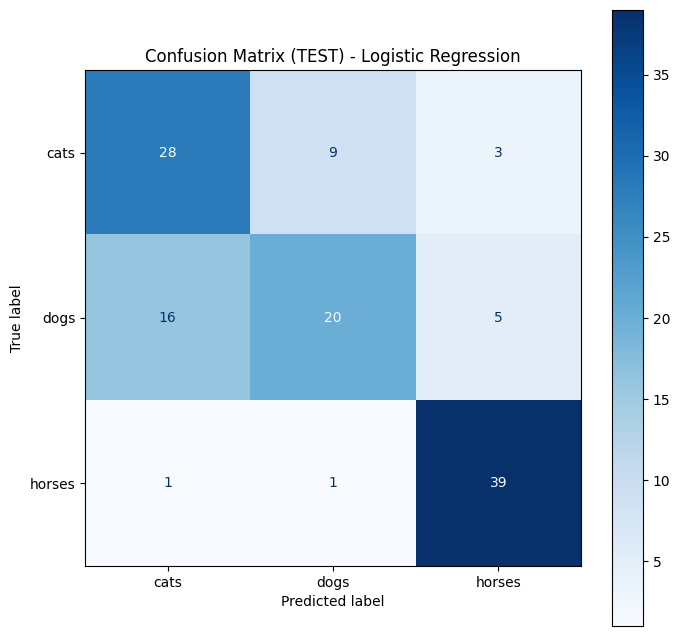

In [ ]:
#results_low = evaluate_models_detailed(X_low, y_low, class_names, "Low-Level Features")
results_low = evaluate_models_detailed(X_low_tr, y_low_tr,
                                       X_low_te, y_low_te,
                                       class_names,
                                       "Low‑Level Features")


### ویژگی های میانی


🔍 Evaluation for: mid‑Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [10:43<00:00, 128.61s/it]




              precision    recall  f1-score   support

        cats       0.70      0.79      0.74       162
        dogs       0.66      0.68      0.67       161
      horses       0.96      0.80      0.87       161

    accuracy                           0.76       484
   macro avg       0.77      0.76      0.76       484
weighted avg       0.77      0.76      0.76       484


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]




              precision    recall  f1-score   support

        cats       0.53      0.21      0.30       162
        dogs       0.47      0.42      0.44       161
      horses       0.46      0.78      0.58       161

    accuracy                           0.47       484
   macro avg       0.49      0.47      0.44       484
weighted avg       0.49      0.47      0.44       484


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]




              precision    recall  f1-score   support

        cats       0.60      0.67      0.64       162
        dogs       0.55      0.53      0.54       161
      horses       0.87      0.79      0.83       161

    accuracy                           0.67       484
   macro avg       0.67      0.67      0.67       484
weighted avg       0.67      0.67      0.67       484


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [00:31<00:00,  6.26s/it]




              precision    recall  f1-score   support

        cats       0.77      0.87      0.82       162
        dogs       0.78      0.71      0.74       161
      horses       0.93      0.90      0.91       161

    accuracy                           0.83       484
   macro avg       0.83      0.83      0.83       484
weighted avg       0.83      0.83      0.83       484


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]




              precision    recall  f1-score   support

        cats       0.60      0.65      0.63       162
        dogs       0.57      0.57      0.57       161
      horses       0.86      0.79      0.82       161

    accuracy                           0.67       484
   macro avg       0.68      0.67      0.67       484
weighted avg       0.68      0.67      0.67       484


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]




              precision    recall  f1-score   support

        cats       0.72      0.55      0.62       162
        dogs       0.53      0.81      0.64       161
      horses       0.91      0.66      0.77       161

    accuracy                           0.67       484
   macro avg       0.72      0.67      0.68       484
weighted avg       0.72      0.67      0.68       484


🏆 Best model based on Accuracy: **Logistic Regression** with Accuracy = 0.8265

📌 FINAL TEST REPORT for **Logistic Regression**


              precision    recall  f1-score   support

        cats       0.77      0.90      0.83        40
        dogs       0.85      0.68      0.76        41
      horses       0.95      0.98      0.96        41

    accuracy                           0.85       122
   macro avg       0.86      0.85      0.85       122
weighted avg       0.86      0.85      0.85       122



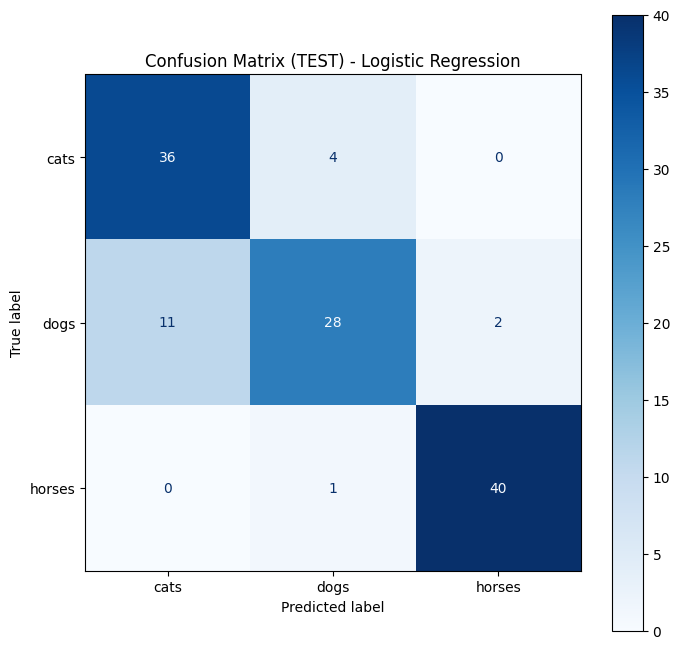

In [ ]:
#results_mid = evaluate_models_detailed(X_mid, y_mid, class_names, "Mid-Level Features")
results_mid = evaluate_models_detailed(X_mid_tr, y_mid_tr,
                                       X_mid_te, y_mid_te,
                                       class_names,
                                       "mid‑Level Features")


### ویژگی های سطح بالا


🔍 Evaluation for: High‑Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]




              precision    recall  f1-score   support

        cats       0.98      0.96      0.97       162
        dogs       0.96      0.98      0.97       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:00<00:00, 44.63it/s]




              precision    recall  f1-score   support

        cats       0.95      0.97      0.96       162
        dogs       0.97      0.94      0.96       161
      horses       0.99      1.00      1.00       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]




              precision    recall  f1-score   support

        cats       0.99      0.94      0.97       162
        dogs       0.94      0.99      0.96       161
      horses       0.99      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]




              precision    recall  f1-score   support

        cats       0.97      0.96      0.97       162
        dogs       0.96      0.98      0.97       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]




              precision    recall  f1-score   support

        cats       0.99      0.93      0.96       162
        dogs       0.94      0.99      0.96       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:00<00:00, 75.96it/s]




              precision    recall  f1-score   support

        cats       0.98      0.93      0.96       162
        dogs       0.93      0.98      0.96       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484


🏆 Best model based on Accuracy: **SVM** with Accuracy = 0.9793

📌 FINAL TEST REPORT for **SVM**


              precision    recall  f1-score   support

        cats       1.00      1.00      1.00        40
        dogs       1.00      1.00      1.00        41
      horses       1.00      1.00      1.00        41

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



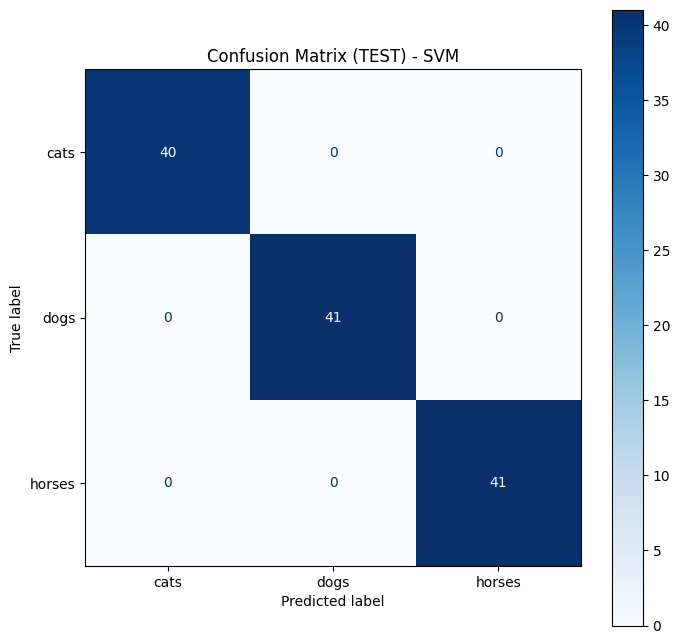

In [ ]:
#results_high = evaluate_models_detailed(X_high, y_high, class_names, "High-Level Features")
results_high = evaluate_models_detailed(X_high_tr, y_high_tr,
                                       X_high_te, y_high_te,
                                       class_names,
                                       "High‑Level Features")


# فاز دوم

##with all data

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
X_train = np.concatenate([X_low_tr, X_mid_tr, X_high_tr], axis=1)
# X = np.concatenate([X_mid, X_high], axis=1)
y_train = y_low_tr 

X_test = np.concatenate([X_low_te, X_mid_te, X_high_te], axis=1)
# X = np.concatenate([X_mid, X_high], axis=1)
y_test = y_low_te  



from sklearn.decomposition import PCA
X_train = PCA(n_components=100).fit_transform(X_train)
X_test = PCA(n_components=100).fit_transform(X_test)

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:

# -- تعریف و هایپرتیونینگ جداگانه مدل‌های پایه ---

# SVM Pipeline با StandardScaler
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])
svm_params = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear','poly']
}
svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=10, random_state=42, n_jobs=-1)
svm_cv.fit(X_train, y_train)
print("Best SVM params:", svm_cv.best_params_)

Best SVM params: {'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__C': 1}


In [ ]:
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_iter=10, random_state=42, n_jobs=-1)
rf_cv.fit(X_train, y_train)
print("Best RF params:", rf_cv.best_params_)

Best RF params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': None}


In [ ]:
# Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}
lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, n_iter=6, random_state=42, n_jobs=-1)
lr_cv.fit(X_train, y_train)
print("Best LR params:", lr_cv.best_params_)

Best LR params: {'solver': 'saga', 'penalty': 'l2', 'C': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:

# Naive Bayes 
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)


GaussianNB()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_cv = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=3, n_iter=5, random_state=42, n_jobs=-1
)
knn_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 5, 7],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp_cv = RandomizedSearchCV(
    MLPClassifier(max_iter=1000),
    mlp_params,
    cv=3, n_iter=5, random_state=42, n_jobs=-1
)
mlp_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001],
                                        'hidden_layer_sizes': [(100,),
                                                               (50, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam']},
                   random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_cv = RandomizedSearchCV(
    GradientBoostingClassifier(),
    gb_params,
    cv=3, n_iter=5, random_state=42, n_jobs=-1
)
gb_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 100]},
                   random_state=42)

In [ ]:
# ---  ساخت مدل‌های پایه با بهترین پارامترها ---

best_svm = svm_cv.best_estimator_
best_rf = rf_cv.best_estimator_
best_lr = lr_cv.best_estimator_
best_gb = gb_cv.best_estimator_
best_mlp = mlp_cv.best_estimator_
best_knn = knn_cv.best_estimator_


In [ ]:

# ---  ساخت مدل Stacking ---
base_learners = [
    ('svm', best_svm),
    ('rf', best_rf),
    ('lr', best_lr),
    ('nb', nb_model),
    ('knn', best_knn),
    ('mlp', best_mlp),
    ('gb', best_gb)
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# ---  آموزش مدل Stacking ---
stacking_clf.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('svm',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                                 SVC(C=1, gamma='auto',
                                                     probability=True))])),
                               ('rf',
                                RandomForestClassifier(min_samples_split=5,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42,
                                                   solver='saga')),
                               ('nb', GaussianNB()),
                               ('knn',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=7,
                                                     weights='distance')),
                               ('mlp',
                                MLPClassifier(activation='tanh', alpha=0.001,
                                              hidden_layer_sizes=(50, 50),
                                              max_iter=1000)),
                               ('gb', GradientBoostingClassifier(max_depth=5))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1)


📊 [Train] Accuracy: 0.9979338842975206
📊 [Train] Classification Report:
              precision    recall  f1-score   support

        cats       1.00      0.99      1.00       162
        dogs       0.99      1.00      1.00       161
      horses       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484

🔍 Accuracy: 0.4098360655737705
🔍 Precision (macro): 0.3994559531282695
🔍 Recall (macro): 0.40873983739837394
🔍 F1 Score (macro): 0.39334884021451183

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.28      0.33        40
           1       0.33      0.29      0.31        41
           2       0.46      0.66      0.54        41

    accuracy                           0.41       122
   macro avg       0.40      0.41      0.39       122
weighted avg       0.40      0.41      0.39 

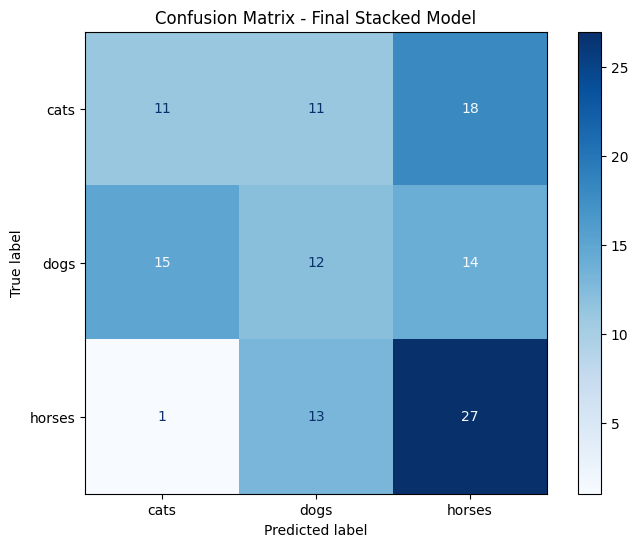

In [ ]:

#  ارزیابی روی داده‌های آموزش
y_train_pred = stacking_clf.predict(X_train)

print("\n📊 [Train] Accuracy:", accuracy_score(y_train, y_train_pred))
print("📊 [Train] Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=class_names))

# --- ارزیابی نهایی---
y_pred = stacking_clf.predict(X_test)

print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Final Stacked Model")
plt.grid(False)
plt.show()


##ترکیب فاز یک و دو

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import numpy as np

X_low_train, X_low_test, y_low_train, y_low_test =X_low_tr , X_low_te, y_low_tr , y_low_te
X_mid_train, X_mid_test, y_mid_train, y_mid_test = X_mid_tr , X_mid_te, y_mid_tr , y_mid_te
X_high_train, X_high_test, y_high_train, y_high_test  = X_high_tr , X_high_te, y_high_tr , y_high_te

# تعریف base learners برای آموزش جداگانه
lr_low = LogisticRegression(max_iter=1000)
lr_mid = LogisticRegression(max_iter=1000)
lr_high = LogisticRegression(max_iter=1000)
rf_low = RandomForestClassifier()
svm_mid = SVC(probability=True)

# گرفتن خروجی احتمالاتی از base learners با cross_val_predict 
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# گرفتن پیش‌بینی‌های OOF برای هر base learner روی داده آموزش
proba_lr_low  = cross_val_predict(lr_low,  X_low_train,  y_low_train, cv=cv, method='predict_proba')
proba_lr_mid  = cross_val_predict(lr_mid,  X_mid_train,  y_mid_train, cv=cv, method='predict_proba')
proba_lr_high = cross_val_predict(lr_high, X_high_train, y_high_train, cv=cv, method='predict_proba')
proba_rf_low  = cross_val_predict(rf_low,  X_low_train,  y_low_train, cv=cv, method='predict_proba')
proba_svm_mid = cross_val_predict(svm_mid, X_mid_train,  y_mid_train, cv=cv, method='predict_proba')

# ترکیب ویژگی‌های پیش‌بینی‌شده برای ساخت داده ورودی به meta-model
X_meta_train = np.hstack([proba_lr_low, proba_lr_mid, proba_lr_high, proba_rf_low, proba_svm_mid])

# آموزش meta-model
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta_train, y_train)

# حالا base مدل‌ها رو روی کل داده آموزش  تا روی تست هم بتونیم پیش‌بینی کنیم
lr_low.fit(X_low_train, y_low_train)
lr_mid.fit(X_mid_train, y_mid_train)
lr_high.fit(X_high_train, y_high_train)
rf_low.fit(X_low_train, y_low_train)
svm_mid.fit(X_mid_train, y_mid_train)

# پیش‌بینی احتمالاتی روی test
proba_lr_low_test  = lr_low.predict_proba(X_low_test)
proba_lr_mid_test  = lr_mid.predict_proba(X_mid_test)
proba_lr_high_test = lr_high.predict_proba(X_high_test)
proba_rf_low_test  = rf_low.predict_proba(X_low_test)
proba_svm_mid_test = svm_mid.predict_proba(X_mid_test)

# ساخت ویژگی‌های تست برای meta-model
X_meta_test = np.hstack([proba_lr_low_test, proba_lr_mid_test, proba_lr_high_test,
                         proba_rf_low_test, proba_svm_mid_test])

final_preds = meta_model.predict(X_meta_test)


from sklearn.metrics import accuracy_score
print(classification_report(y_test, final_preds))
# دقت روی داده تست
accuracy_test = accuracy_score(y_test, final_preds)
print(f"Test Accuracy: {accuracy_test:.4f}")

# دقت روی داده آموزش
train_preds = meta_model.predict(X_meta_train)
accuracy_train = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {accuracy_train:.4f}")
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()

Test Accuracy: 0.7320
Train Accuracy: 0.7209


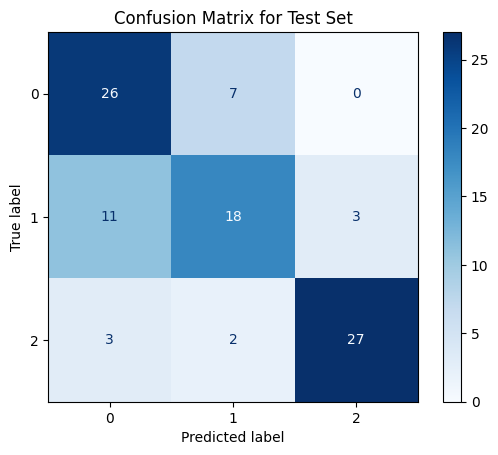

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('lr_low', lr_low),
        ('lr_mid', lr_mid),
        ('lr_high', lr_high),
        ('rf_low', rf_low),
        ('svm_mid', svm_mid)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=False  
)

# ساخت یک داده ترکیبی برای همه ویژگی‌ها (مثلاً concatenate)
X_train_combined = np.hstack([X_low_train, X_mid_train, X_high_train])
X_test_combined = np.hstack([X_low_test, X_mid_test, X_high_test])

stacking_model.fit(X_train_combined, y_train)
final_preds = stacking_model.predict(X_test_combined)

print(classification_report(y_test, final_preds))

# دقت روی داده تست
accuracy_test = accuracy_score(y_test, final_preds)
print(f"Test Accuracy: {accuracy_test:.4f}")

# دقت روی داده آموزش
train_preds = meta_model.predict(X_meta_train)
accuracy_train = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {accuracy_train:.4f}")
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()


              precision    recall  f1-score   support

           0       0.61      0.76      0.68        33
           1       0.60      0.47      0.53        32
           2       0.87      0.84      0.86        32

    accuracy                           0.69        97
   macro avg       0.69      0.69      0.69        97
weighted avg       0.69      0.69      0.69        97



Test Accuracy: 0.6907
Train Accuracy: 0.7209


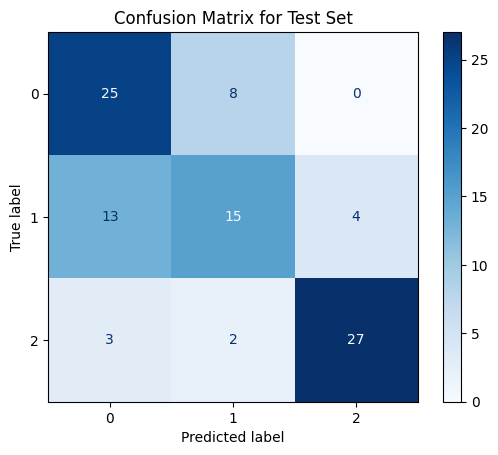

##با کتابخانه

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

def stack(X_train , y_train , X_test, y_test):
  # تبدیل برچسب‌ها به binary برای رسم ROC 
  y_bin = label_binarize(y_train, classes=np.unique(y_train))

  # --- SVM ---
  svm_pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('svc', SVC(probability=True))
  ])
  svm_params = {
      'svc__C': [0.1, 1, 10],
      'svc__gamma': ['scale', 'auto'],
      'svc__kernel': ['rbf', 'linear']
  }
  svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=6, random_state=42)

  # --- Random Forest ---
  rf_params = {
      'n_estimators': [50, 100, 150],
      'max_depth': [None, 10, 20],
      'min_samples_split': [2, 5]
  }
  rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=6, random_state=42)

  # --- Logistic Regression ---
  lr_params = {
      'C': [0.1, 1, 10],
      'penalty': ['l2'],
      'solver': ['liblinear']
  }
  lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_iter=6, random_state=42)

  # --- Naive Bayes ---
  nb_model = GaussianNB()

  # 3. تعریف StackingClassifier با Cross-Validation داخلی
  from sklearn.neighbors import KNeighborsClassifier

  knn_params = {
      'n_neighbors': [3, 5, 7],
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }
  knn_cv = RandomizedSearchCV(KNeighborsClassifier(),knn_params,cv=3, n_iter=6, random_state=42)

  from sklearn.neural_network import MLPClassifier
  mlp_params = {
      'hidden_layer_sizes': [(100,), (50, 50)],
      'activation': ['relu', 'tanh'],
      'solver': ['adam'],
      'alpha': [0.0001, 0.001],
      'learning_rate': ['constant', 'adaptive']
  }
  mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000), mlp_params,cv=3, n_iter=6, random_state=42)

  from sklearn.ensemble import GradientBoostingClassifier
  gb_params = {
      'n_estimators': [50, 100],
      'learning_rate': [0.05, 0.1],
      'max_depth': [3, 5]
  }
  gb_cv = RandomizedSearchCV(GradientBoostingClassifier(),gb_params,cv=3, n_iter=5, random_state=42)

  # StackingClassifier با Cross-Validation داخلی
  base_learners = [
      ('svm', svm_cv),
      ('rf', rf_cv),
      ('lr', lr_cv),
      ('nb', nb_model),
      # ('knn', knn_cv),
      ('mlp', mlp_cv),
      # ('gb', gb_cv)
  ]
  meta_model = LogisticRegression(max_iter=1000)

  stack_clf = StackingClassifier(
      estimators=base_learners,
      final_estimator=meta_model,
      cv=5, 
      n_jobs=-1,
      passthrough=False
  )

  #  آموزش مدل
  stack_clf.fit(X_train, y_train)

  #  پیش‌بینی و ارزیابی
  y_pred = stack_clf.predict(X_test)
  print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
  print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
  print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
  print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
  print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

  # دقت روی داده آموزش
  train_preds = stack_clf.predict(X_train)
  accuracy_train = accuracy_score(y_train, train_preds)
  print(f"Train Accuracy: {accuracy_train:.4f}")

  #  Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap='Blues', values_format='d')
  plt.title("Confusion Matrix - Stacked Model")
  plt.grid(False)
  plt.show()

  #  ROC Curve (multi-class)
  if len(np.unique(y_train)) == 3:
      y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
      y_score = stack_clf.predict_proba(X_test)
      RocCurveDisplay.from_predictions(y_test_bin.ravel(), y_score.ravel())
      plt.title("Multi-Class ROC Curve")
      plt.show()

  # # 8. Learning Curve
  # train_sizes, train_scores, test_scores = learning_curve(
  #     stack_clf, X, y, cv=StratifiedKFold(5), n_jobs=-1,
  #     train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
  # )

  # train_mean = train_scores.mean(axis=1)
  # test_mean = test_scores.mean(axis=1)

  # plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
  # plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
  # plt.xlabel('Training Set Size')
  # plt.ylabel('Accuracy')
  # plt.title('Learning Curve - Stacked Model')
  # plt.legend()
  # plt.grid(True)
  # plt.show()



###x_high

🔍 Accuracy: 1.0
🔍 Precision (macro): 1.0
🔍 Recall (macro): 1.0
🔍 F1 Score (macro): 1.0

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        41

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122

Train Accuracy: 1.0000


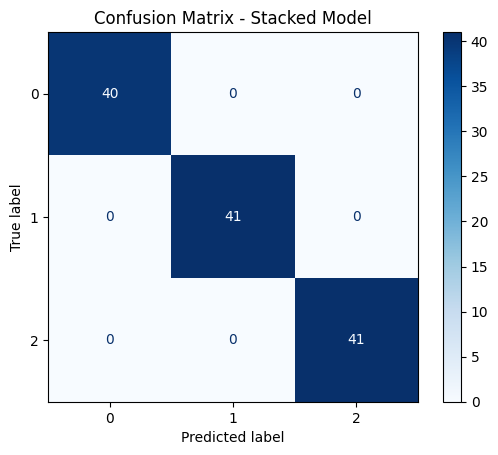

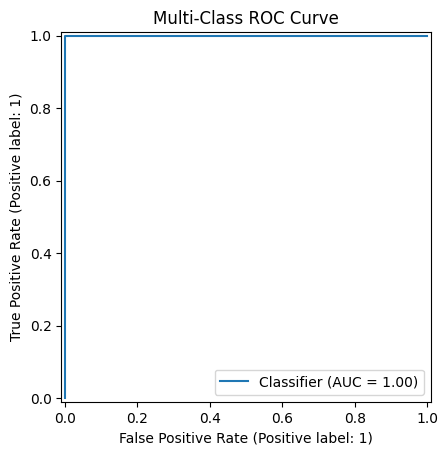

In [ ]:
stack(X_high_tr, y_high_tr , X_high_te , y_high_te)

###x_mid

🔍 Accuracy: 0.45161290322580644
🔍 Precision (macro): 0.43675789023787587
🔍 Recall (macro): 0.45303460011344293
🔍 F1 Score (macro): 0.42320378930548425

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.17      0.24        41
           1       0.45      0.49      0.47        43
           2       0.47      0.70      0.57        40

    accuracy                           0.45       124
   macro avg       0.44      0.45      0.42       124
weighted avg       0.44      0.45      0.42       124

Train Accuracy: 0.9898


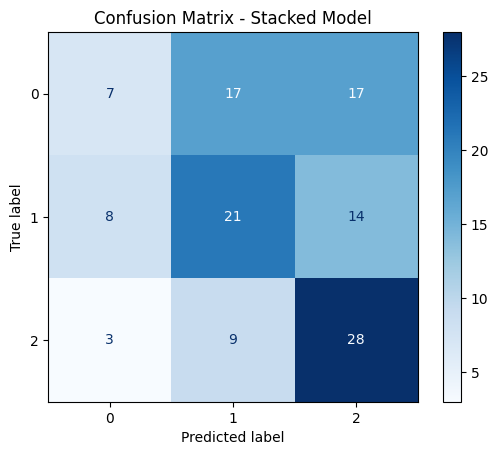

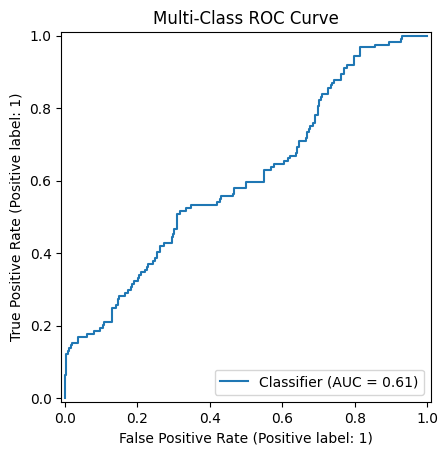

In [20]:
from sklearn.decomposition import PCA
X_train = PCA(n_components=40).fit_transform(X_mid_tr)
X_test = PCA(n_components=40).fit_transform(X_mid_te)
stack(X_train , y_mid_tr , X_test , y_mid_te)

###x_low

🔍 Accuracy: 0.4426229508196721
🔍 Precision (macro): 0.4342842842842843
🔍 Recall (macro): 0.441260162601626
🔍 F1 Score (macro): 0.4371846929986465

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.28      0.29        40
           1       0.45      0.44      0.44        41
           2       0.56      0.61      0.58        41

    accuracy                           0.44       122
   macro avg       0.43      0.44      0.44       122
weighted avg       0.44      0.44      0.44       122

Train Accuracy: 1.0000


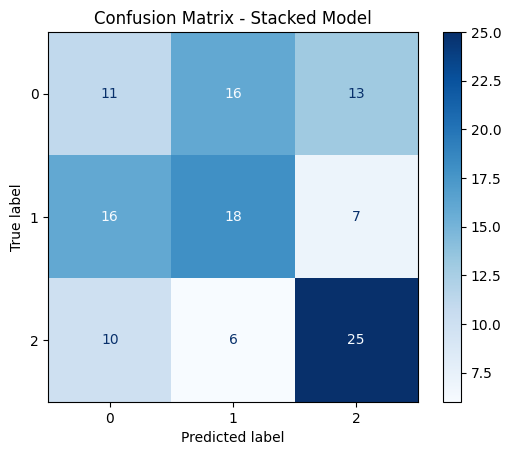

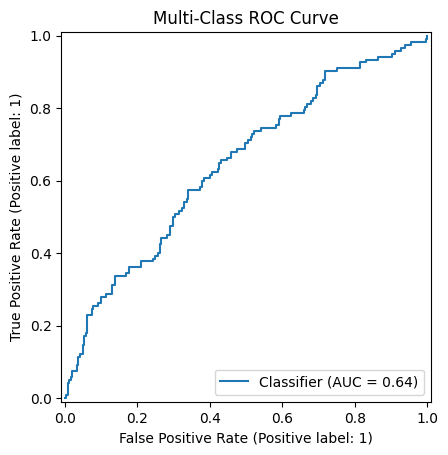

In [ ]:
from sklearn.decomposition import PCA
X_train = PCA(n_components=40).fit_transform(X_low_tr)
X_test = PCA(n_components=40).fit_transform(X_low_te)
stack(X_train,  y_low_tr, X_test, y_low_te)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['cats', 'dogs', 'horses']


Extracting Features: 100%|██████████| 4/4 [00:00<00:00, 34.94it/s]


=== HIGH LEVEL ===


Accuracy: 0.9758064516129032

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        41
           1       0.98      0.95      0.96        43
           2       1.00      0.97      0.99        40

    accuracy                           0.98       124
   macro avg       0.98      0.98      0.98       124
weighted avg       0.98      0.98      0.98       124



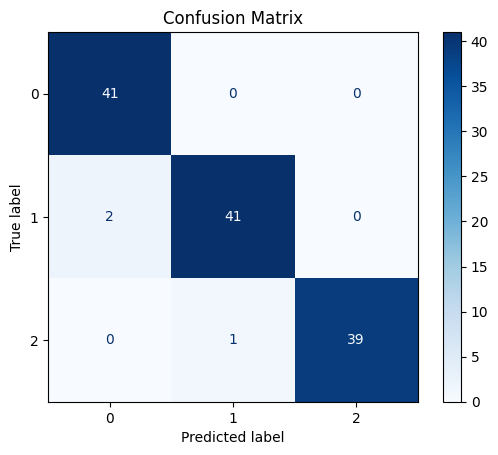

Train Accuracy: 1.0

=== MID LEVEL (PCA) ===
Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.79        41
           1       0.63      0.74      0.68        43
           2       0.93      0.70      0.80        40

    accuracy                           0.75       124
   macro avg       0.78      0.75      0.76       124
weighted avg       0.77      0.75      0.75       124



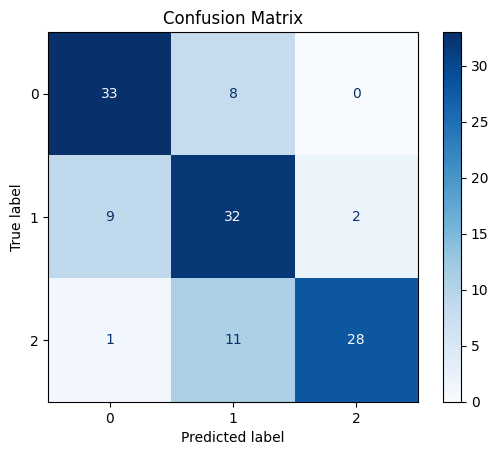

Train Accuracy: 0.9552845528455285

=== LOW LEVEL (PCA) ===
Accuracy: 0.6693548387096774

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65        41
           1       0.57      0.65      0.61        43
           2       0.77      0.75      0.76        40

    accuracy                           0.67       124
   macro avg       0.68      0.67      0.67       124
weighted avg       0.68      0.67      0.67       124



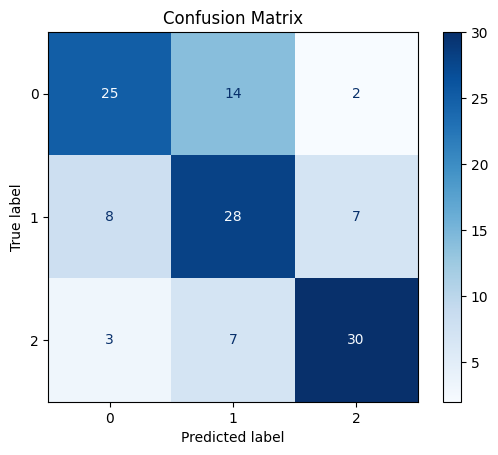

Train Accuracy: 0.975609756097561


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

# Transform with Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset
dataset_path = "/content/drive/MyDrive/dataset3"
dataset = ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# Split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.targets)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# ResNet Feature Extractors
import torch.nn as nn
from torchvision import models
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in resnet.parameters():
    param.requires_grad = False

features_low = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
features_mid = nn.Sequential(features_low, resnet.layer1, resnet.layer2)
features_high = nn.Sequential(features_mid, resnet.layer3, resnet.layer4, resnet.avgpool)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features_low, features_mid, features_high = features_low.to(device), features_mid.to(device), features_high.to(device)

# Feature Extraction Function
def extract_features(dataloader, feature_extractor):
    features, labels = [], []
    feature_extractor.eval()
    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract Features
X_high_tr, y_high_tr = extract_features(train_loader, features_high)
X_high_te, y_high_te = extract_features(test_loader, features_high)
X_mid_tr, y_mid_tr = extract_features(train_loader, features_mid)
X_mid_te, y_mid_te = extract_features(test_loader, features_mid)
X_low_tr, y_low_tr = extract_features(train_loader, features_low)
X_low_te, y_low_te = extract_features(test_loader, features_low)

# PCA Function
def apply_pca(X_train, X_test, n_components=40):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X_train), pca.transform(X_test)

# Model Training Function
def train_stack(X_train, y_train, X_test, y_test):
    # Pipelines
    svm = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])
    svm_cv = RandomizedSearchCV(svm, {
        'svc__C': [0.1, 1, 10],
        'svc__gamma': ['scale', 'auto'],
        'svc__kernel': ['rbf', 'linear']
    }, n_iter=6, cv=3, random_state=42)

    rf_cv = RandomizedSearchCV(RandomForestClassifier(), {
        'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5]
    }, n_iter=6, cv=3, random_state=42)

    lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']
    }, n_iter=6, cv=3, random_state=42)

    knn_cv = RandomizedSearchCV(KNeighborsClassifier(), {
        'n_neighbors': [3, 5], 'weights': ['uniform'], 'metric': ['euclidean']
    }, n_iter=4, cv=3, random_state=42)

    mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000, early_stopping=True), {
        'hidden_layer_sizes': [(100,), (50, 50)],
        'activation': ['relu'],
        'alpha': [0.001, 0.01],
        'learning_rate': ['constant']
    }, n_iter=4, cv=3, random_state=42)

    base_models = [
        ('svm', svm_cv),
        ('rf', rf_cv),
        ('lr', lr_cv),
        ('nb', GaussianNB()),
        ('knn', knn_cv),
        ('mlp', mlp_cv)
    ]
    meta = LogisticRegression(max_iter=1000)

    stack = StackingClassifier(estimators=base_models, final_estimator=meta, cv=5, n_jobs=-1)
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    print("Train Accuracy:", accuracy_score(y_train, stack.predict(X_train)))

# Run
print("\n=== HIGH LEVEL ===")
train_stack(X_high_tr, y_high_tr, X_high_te, y_high_te)

print("\n=== MID LEVEL (PCA) ===")
X_mid_tr_pca, X_mid_te_pca = apply_pca(X_mid_tr, X_mid_te)
train_stack(X_mid_tr_pca, y_mid_tr, X_mid_te_pca, y_mid_te)

print("\n=== LOW LEVEL (PCA) ===")
X_low_tr_pca, X_low_te_pca = apply_pca(X_low_tr, X_low_te)
train_stack(X_low_tr_pca, y_low_tr, X_low_te_pca, y_low_te)


## دستی

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

def stack_handy(X_train, y_train, X_test, y_test):
    # --- مدل‌ها با Hypertuning ---
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(probability=True))
    ])
    svm_params = {
        'svc__C': [0.1, 1, 10],
        'svc__gamma': ['scale', 'auto'],
        'svc__kernel': ['rbf', 'linear']
    }
    svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=6, random_state=42)

    rf_params = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=6, random_state=42)

    lr_params = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    }
    lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_iter=6, random_state=42)

    nb_model = GaussianNB()

    from sklearn.neighbors import KNeighborsClassifier
    knn_params = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    knn_cv = RandomizedSearchCV(KNeighborsClassifier(), knn_params, cv=3, n_iter=6, random_state=42)

    from sklearn.neural_network import MLPClassifier
    mlp_params = {
        'hidden_layer_sizes': [(100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }
    mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000), mlp_params, cv=3, n_iter=6, random_state=42)

    # --- Cross-Validation برای OOF ---
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    proba_svm = cross_val_predict(svm_cv, X_train, y_train, cv=cv, method='predict_proba')
    proba_rf = cross_val_predict(rf_cv, X_train, y_train, cv=cv, method='predict_proba')
    proba_lr = cross_val_predict(lr_cv, X_train, y_train, cv=cv, method='predict_proba')
    proba_nb = cross_val_predict(nb_model, X_train, y_train, cv=cv, method='predict_proba')
    proba_knn = cross_val_predict(knn_cv, X_train, y_train, cv=cv, method='predict_proba')
    proba_mlp = cross_val_predict(mlp_cv, X_train, y_train, cv=cv, method='predict_proba')

    # ترکیب ویژگی‌ها برای meta-model
    X_meta_train = np.hstack([proba_svm, proba_rf, proba_lr, proba_nb, proba_knn, proba_mlp])

    # آموزش meta-model
    meta_model = LogisticRegression(max_iter=1000)
    meta_model.fit(X_meta_train, y_train)

    # آموزش base learnerها روی کل X_train
    svm_cv.fit(X_train, y_train)
    rf_cv.fit(X_train, y_train)
    lr_cv.fit(X_train, y_train)
    nb_model.fit(X_train, y_train)
    knn_cv.fit(X_train, y_train)
    mlp_cv.fit(X_train, y_train)

    # پیش‌بینی احتمالاتی روی X_test
    proba_svm_test = svm_cv.predict_proba(X_test)
    proba_rf_test = rf_cv.predict_proba(X_test)
    proba_lr_test = lr_cv.predict_proba(X_test)
    proba_nb_test = nb_model.predict_proba(X_test)
    proba_knn_test = knn_cv.predict_proba(X_test)
    proba_mlp_test = mlp_cv.predict_proba(X_test)

    # ساخت X_meta_test
    X_meta_test = np.hstack([proba_svm_test, proba_rf_test, proba_lr_test, proba_nb_test, proba_knn_test, proba_mlp_test])

    # پیش‌بینی نهایی
    final_preds = meta_model.predict(X_meta_test)

    # گزارش‌ها
    print("\nClassification Report:")
    print(classification_report(y_test, final_preds))

    print(f"Test Accuracy: {accuracy_score(y_test, final_preds):.4f}")
    train_preds = meta_model.predict(X_meta_train)
    print(f"Train Accuracy: {accuracy_score(y_train, train_preds):.4f}")

    cm = confusion_matrix(y_test, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Test Set")
    plt.show()


###low

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_sea


Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.20      0.22        41
           1       0.26      0.28      0.27        43
           2       0.58      0.65      0.61        40

    accuracy                           0.37       124
   macro avg       0.36      0.37      0.37       124
weighted avg       0.36      0.37      0.36       124

Test Accuracy: 0.3710
Train Accuracy: 0.7236


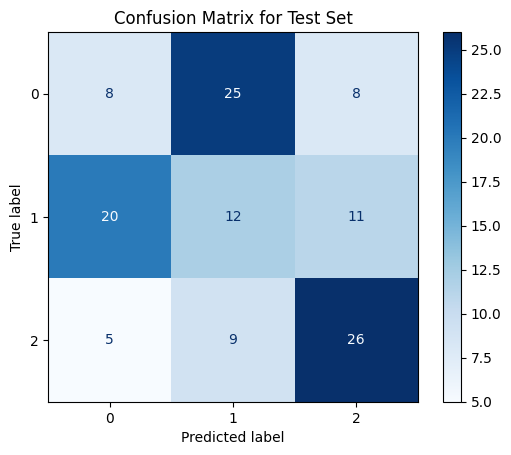

In [11]:
from sklearn.decomposition import PCA
X_train = PCA(n_components=40).fit_transform(X_low_tr)
X_test = PCA(n_components=40).fit_transform(X_low_te)

stack_handy(X_train, y_low_tr, X_test, y_low_te)

###mid

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_sea


Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.07      0.10        41
           1       0.35      0.56      0.43        43
           2       0.54      0.50      0.52        40

    accuracy                           0.38       124
   macro avg       0.35      0.38      0.35       124
weighted avg       0.35      0.38      0.35       124

Test Accuracy: 0.3790
Train Accuracy: 0.8455


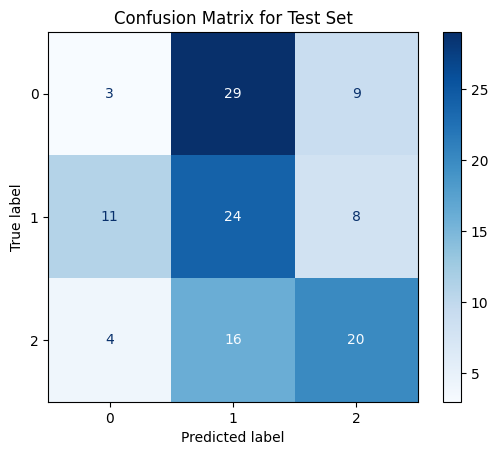

In [14]:
from sklearn.decomposition import PCA
X_train_mid = PCA(n_components=100).fit_transform(X_mid_tr)
X_test_mid = PCA(n_components=100).fit_transform(X_mid_te)

stack_handy(X_train_mid, y_mid_tr, X_test_mid, y_mid_te)
# stack_handy(X_mid_tr, y_mid_tr, X_mid_te, y_mid_te)

###high

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_sea


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       1.00      0.98      0.99        43
           2       1.00      1.00      1.00        40

    accuracy                           0.99       124
   macro avg       0.99      0.99      0.99       124
weighted avg       0.99      0.99      0.99       124

Test Accuracy: 0.9919
Train Accuracy: 0.9837


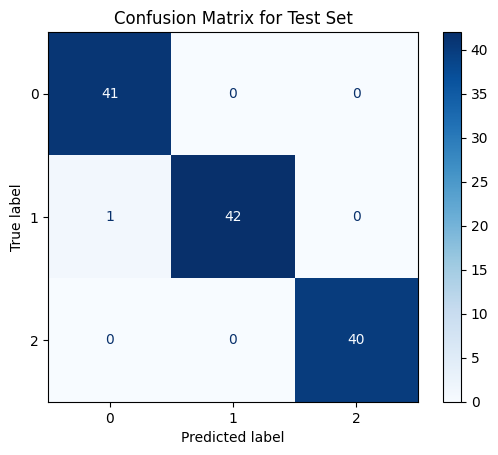

In [9]:

stack_handy(X_high_tr , y_high_tr, X_high_te , y_high_te)



==================== Running LOW ====================

Training SVM...

Training RF...

Training LR...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_sea


Training KNN...

Training MLP...

Training NB...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.60        41
           1       0.62      0.67      0.64        43
           2       0.76      0.72      0.74        40

    accuracy                           0.66       124
   macro avg       0.67      0.66      0.66       124
weighted avg       0.66      0.66      0.66       124

✅ Test Accuracy:  0.6613
✅ Train Accuracy: 0.6138


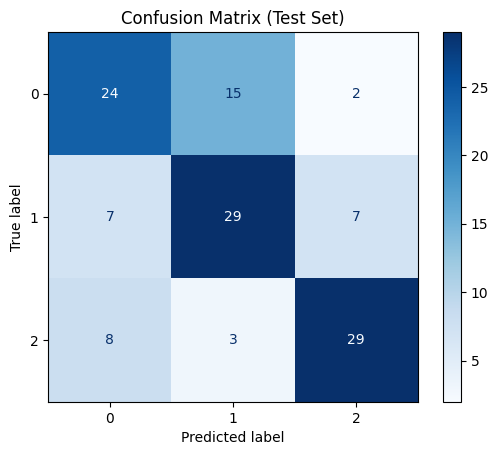



==================== Running MID ====================

Training SVM...

Training RF...

Training LR...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_sea


Training KNN...

Training MLP...

Training NB...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.90      0.76        41
           1       0.71      0.63      0.67        43
           2       0.97      0.70      0.81        40

    accuracy                           0.74       124
   macro avg       0.78      0.74      0.74       124
weighted avg       0.77      0.74      0.74       124

✅ Test Accuracy:  0.7419
✅ Train Accuracy: 0.8435


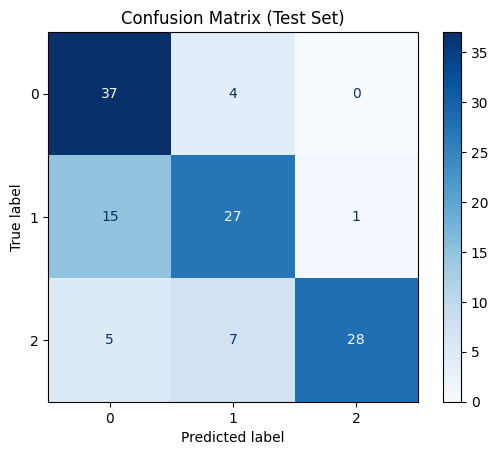



==================== Running HIGH ====================

Training SVM...

Training RF...

Training LR...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_sea


Training KNN...

Training MLP...

Training NB...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       0.98      0.98      0.98        43
           2       1.00      0.97      0.99        40

    accuracy                           0.98       124
   macro avg       0.98      0.98      0.98       124
weighted avg       0.98      0.98      0.98       124

✅ Test Accuracy:  0.9839
✅ Train Accuracy: 0.9715


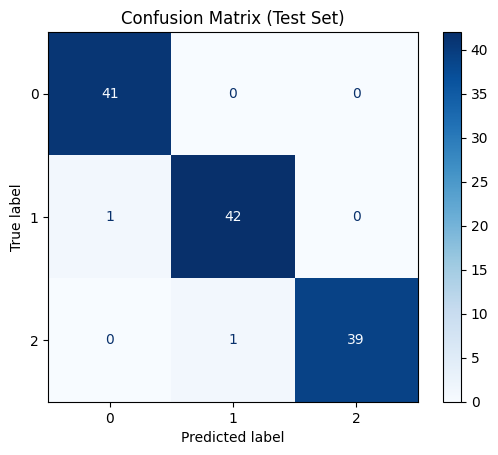

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def get_models():
    svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(probability=True))
    ])
    svm_params = {
        'svc__C': [0.1, 1, 10],
        'svc__gamma': ['scale', 'auto'],
        'svc__kernel': ['rbf', 'linear']
    }

    rf = RandomForestClassifier()
    rf_params = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }

    lr = LogisticRegression(max_iter=1000)
    lr_params = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    }

    knn = KNeighborsClassifier()
    knn_params = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    mlp = MLPClassifier(max_iter=300, early_stopping=True, n_iter_no_change=5)
    mlp_params = {
        'hidden_layer_sizes': [(100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }

    return {
        'svm': (svm, svm_params),
        'rf': (rf, rf_params),
        'lr': (lr, lr_params),
        'knn': (knn, knn_params),
        'mlp': (mlp, mlp_params),
        'nb': (GaussianNB(), None)  # no hyperparams
    }

def stack_handy(X_train, y_train, X_test, y_test):
    models = get_models()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    meta_features_train = []
    meta_features_test = []

    trained_models = {}

    for name, (model, params) in models.items():
        print(f"\nTraining {name.upper()}...")
        if params:
            model_cv = RandomizedSearchCV(model, params, cv=3, n_iter=6, random_state=42)
        else:
            model_cv = model  # GaussianNB
        proba_train = cross_val_predict(model_cv, X_train, y_train, cv=cv, method='predict_proba')
        meta_features_train.append(proba_train)

        # Train on full data
        model_cv.fit(X_train, y_train)
        proba_test = model_cv.predict_proba(X_test)
        meta_features_test.append(proba_test)

        trained_models[name] = model_cv

    # Meta-model
    X_meta_train = np.hstack(meta_features_train)
    X_meta_test = np.hstack(meta_features_test)

    meta_model = LogisticRegression(max_iter=1000)
    meta_model.fit(X_meta_train, y_train)

    final_preds = meta_model.predict(X_meta_test)

    print("\n📊 Classification Report:")
    print(classification_report(y_test, final_preds))
    print(f"✅ Test Accuracy:  {accuracy_score(y_test, final_preds):.4f}")
    train_preds = meta_model.predict(X_meta_train)
    print(f"✅ Train Accuracy: {accuracy_score(y_train, train_preds):.4f}")

    cm = confusion_matrix(y_test, final_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Test Set)")
    plt.show()


def run_pipeline(X_tr, y_tr, X_te, y_te, name=""):
    print(f"\n\n{'='*20} Running {name.upper()} {'='*20}")
    # کاهش ابعاد فقط در low و mid
    if name in ["low", "mid"]:
        pca = PCA(n_components=40, random_state=42)
        X_tr = pca.fit_transform(X_tr)
        X_te = pca.transform(X_te)
    stack_handy(X_tr, y_tr, X_te, y_te)

run_pipeline(X_low_tr, y_low_tr, X_low_te, y_low_te, name="low")
run_pipeline(X_mid_tr, y_mid_tr, X_mid_te, y_mid_te, name="mid")
run_pipeline(X_high_tr, y_high_tr, X_high_te, y_high_te, name="high")
